# TFG Tomás Camero

* [MLP](#MLP)
    * [Inicialización de variables](#Inicialización)
    * [Búsqueda de hiperparámetros](#Búsqueda)
    * [Entrenamiento](#Entrenamiento)
    * [Resultados](#Resultados)
    * [Algunas gráficas](#Gráficas)
* [Keras](#Keras)
    * [Inicialización de variables](#Inicialización2)
    * [Creación del modelo](#Modelo2)
    * [Entrenamiento](#Entrenamiento2)
    * [Resultados](#Resultados2)
* [TensorFlow Quantum](#TensorFlow)
    * [Inicialización de variables](#Inicialización3)
    * [Clases](#Clases)
    * [Creación del modelo híbrido](#Modelo3)
    * [Entrenamiento](#Entrenamiento3)
    * [Resultados](#Resultados3)
* [Qiskit](#qiskit)
    * [Inicialización de variables](#Inicialización4)
    * [Funciones necesarias](#Funciones4)
    * [Creación de la red híbrido](#Modelo4)
    * [Entrenamiento](#Entrenamiento4)
    * [Resultados](#Resultados4)
* [Comparaciones](#comparaciones)

# MLP<a class="anchor" id="MLP"></a>

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import multiprocessing as mp
from matplotlib.patches import Wedge, Circle

%matplotlib inline
import numpy as np
import pandas as pd 
from sklearn import datasets, metrics
import time as time
from sklearn import svm
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier
import seaborn
import cProfile
from io import StringIO
import pstats
import psutil
import threading
cores = psutil.cpu_count()
from sklearn import metrics
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from keras.datasets import mnist
from skimage.transform import resize

## 1. Inicialización de variables <a class="anchor" id="Inicialización"></a>

In [2]:
cpu_percent_list_train_mlp = []
memory_usage_list_train_mlp= []
cpu_percent_list_test_mlp= []
memory_usage_list_test_mlp= []


In [3]:
(train_x, train_y), (test_x, test_y) = mnist.load_data()

train_x = train_x.reshape(60000, 784)
test_x = test_x.reshape(10000, 784)

indices_train = np.where((train_y == 3) | (train_y == 4) | (train_y == 5))
x_train_filtered = train_x[indices_train]
y_train_filtered = train_y[indices_train]


indices_test = np.where((test_y == 3) | (test_y == 4) | (test_y == 5))
x_test_filtered = test_x[indices_test]
y_test_filtered = test_y[indices_test]


train_y = y_train_filtered
test_y = y_test_filtered

train_x = np.array([resize(image, (4, 4)) for image in x_train_filtered])
test_x = np.array([resize(image, (4, 4)) for image in x_test_filtered])

train_x = train_x.reshape(train_x.shape[0], -1)
test_x = test_x.reshape(test_x.shape[0], -1)

train_x = train_x.astype('float32')
test_x = test_x.astype('float32')
train_x /= 255
test_x /= 255

In [4]:
def lists_cpu_and_ram_mlp_train():
    global running
    running = True

    currentProcess = psutil.Process()
    while running:
        cpu_percent_list_train_mlp.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_train_mlp.append(currentProcess.memory_percent())
        
def start_mlp_train():
    global t

    # create thread and start it
    t = threading.Thread(target=lists_cpu_and_ram_mlp_train)
    t.start()

def stop_mlp_train():
    global running
    global t

    # use `running` to stop loop in thread so thread will end
    running = False

    # wait for thread's end
    t.join()

In [5]:
def lists_cpu_and_ram_mlp_test():
    global running
    running = True
    currentProcess = psutil.Process()

    while running:
        cpu_percent_list_test_mlp.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_test_mlp.append(currentProcess.memory_percent())
        
def start_mlp_test():
    global t

    # create thread and start it
    t = threading.Thread(target=lists_cpu_and_ram_mlp_test)
    t.start()

def stop_mlp_test():
    global running
    global t

    # use `running` to stop loop in thread so thread will end
    running = False

    # wait for thread's end
    t.join()

## 2. Funcion para buscar los mejores hiperparámetros <a class="anchor" id="Búsqueda"></a>

In [6]:
def busqueda_de_atributos_mlp(modelo):
    scoring = 'accuracy'
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100), (50, 100), (100, 50), 
                               (50, 50, 50), (100, 100, 100), (50, 100, 50), (100, 50, 100),
                               (50, 100, 50, 100), (100, 50, 100, 50)],
        'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'solver': ['lbfgs', 'sgd', 'adam'],
        'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
        'max_iter': [15000,20000,25000]
    }
    
    grid_search_mlp = HalvingGridSearchCV(estimator=modelo, param_grid=param_grid, scoring=scoring, cv=10)
    grid_search_mlp.fit(train_x, train_y)

    return [grid_search_mlp.best_estimator_,grid_search_mlp.best_params_]

## 3. Entrenamiento <a class="anchor" id="Entrenamiento"></a>

In [7]:
def entrenamientoyresultados_mlp(modelo):
    
    clf_mlp = modelo
    #Empezamos a contar el tiempo de entrenamiento
    startTrainingTime_mlp = time.time()
    
    # Entrenamiento
    start_mlp_train()
    try:
        clf_mlp.fit(train_x, train_y)
    finally:
        stop_mlp_train()


    #Terminamos de contar el tiempo de entrenamiento
    endTrainingTime_mlp = time.time()

    #Calculamos el tiempo de entrenamiento
    trainingTime_mlp = endTrainingTime_mlp - startTrainingTime_mlp  

    validResults_mlp = 0

    #Empezamos a contar el tiempo de testeo
    
    startTestingTime_mlp = time.time()
    
    start_mlp_test()
    try:
        
        predicted_mlp = clf_mlp.predict(test_x)
        precision_mlp = metrics.accuracy_score(test_y, predicted_mlp)
        
    finally:
        stop_mlp_test()
    
    #Terminamos de contar el tiempo de testeo
    endTestingTime_mlp = time.time()

    #Calculamos el tiempo de testeo
    testingTime_mlp = endTestingTime_mlp - startTestingTime_mlp  # Calculation of testing time
    
    #precision_mlp = round((validResults_mlp / testingSamples) * 100, 2)
    
    return precision_mlp*100,trainingTime_mlp, testingTime_mlp,clf_mlp,predicted_mlp

## 4. Resultados <a class="anchor" id="Resultados2"></a>

In [10]:
parametros_mlp = busqueda_de_atributos_mlp(MLPClassifier())

In [11]:
print(parametros_mlp[0])

MLPClassifier(activation='identity', alpha=0.001, max_iter=25000)


In [12]:
print(parametros_mlp[1])

{'activation': 'identity', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 25000, 'solver': 'adam'}


In [13]:
#modelo_mlp = MLPClassifier(alpha=0.05, max_iter=7000,activation = 'relu', hidden_layer_sizes= (100,100,), solver = 'adam', learning_rate = 'adaptive')
modelo_mlp = MLPClassifier(activation='identity', alpha=0.001, hidden_layer_sizes=(100,), learning_rate='constant', max_iter=25000, solver='adam')
resultados_mlp = entrenamientoyresultados_mlp(modelo_mlp)

In [14]:
#print("Resultados con parametros: " + str(modelo[1]))
print("-------------------------------")
#print("Muestras de entrenamiento: ", trainingSamples)
print("Tiempo de entrenamiento: ", round(resultados_mlp[1], 2), " s")
#print("Muestras de testeo: ", testingSamples)
print("Tiempo de testeo: ", round(resultados_mlp[2], 2), " s")
print("Precisión: ", resultados_mlp[0], "%")
print("-------------------------------")
print("Uso de CPU en entrenamiento: ", cpu_percent_list_train_mlp)
print("-------------------------------")
print("Uso de CPU en test: ", cpu_percent_list_test_mlp)
print("-------------------------------")
print("Uso de RAM en entrenamiento: ", memory_usage_list_train_mlp)
print("-------------------------------")
print("Uso de RAM en test: ", memory_usage_list_test_mlp)

-------------------------------
Tiempo de entrenamiento:  22.04  s
Tiempo de testeo:  1.0  s
Precisión:  68.48127600554785 %
-------------------------------
Uso de CPU en entrenamiento:  [91.89999999999999, 99.58333333333333, 99.96666666666665, 99.97500000000001, 99.85000000000001, 99.97500000000001, 99.96666666666665, 99.99166666666667, 99.97500000000001, 98.63333333333333, 97.575, 99.97500000000001, 98.22500000000001, 99.83333333333333, 99.14166666666667, 99.96666666666665, 99.825, 99.97500000000001, 99.96666666666665, 99.96666666666665, 99.97500000000001, 99.8, 99.98333333333333, 99.97500000000001, 100.05833333333334, 99.97500000000001, 99.89166666666667, 100.05833333333334, 99.47500000000001, 99.88333333333333, 99.97500000000001, 100.0, 99.89166666666667, 99.89166666666667, 99.97500000000001, 100.05, 99.88333333333333, 99.91666666666667, 99.97500000000001, 99.88333333333333, 99.98333333333333, 99.97500000000001, 99.96666666666665, 99.71666666666665, 99.89166666666667, 99.8916666666

## 5. Algunas gráficas <a class="anchor" id="Gráficas"></a>

In [15]:
predicion_mlp = resultados_mlp[4]

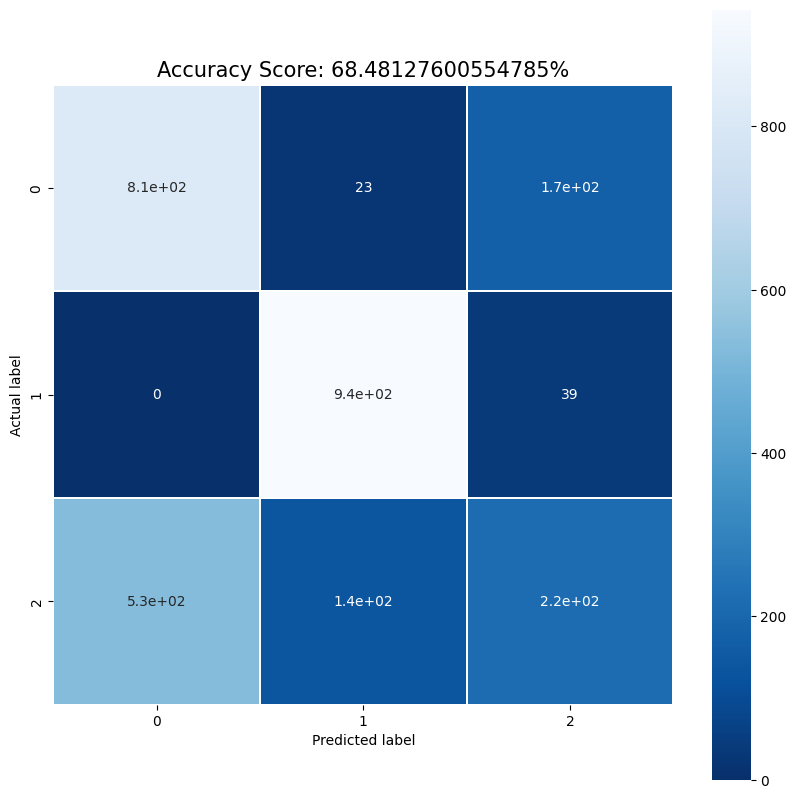

In [16]:
cm = metrics.confusion_matrix(test_y, predicion_mlp)
plt.figure(figsize=(10,10))
seaborn.heatmap(cm, annot=True, linewidths=.25, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}%'.format(resultados_mlp[0])
plt.title(all_sample_title, size = 15);

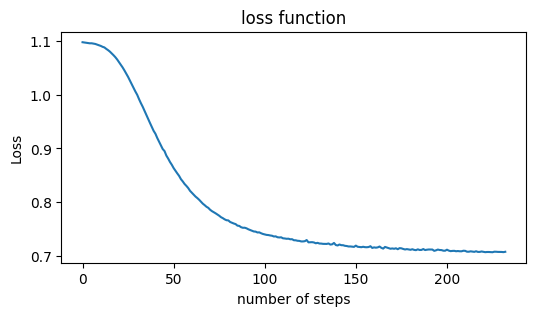

In [17]:
fig, ax = plt.subplots(figsize=(6,3))
modelo = resultados_mlp[3]
ax.plot(modelo.loss_curve_)

plt.xlabel("number of steps") 
plt.ylabel("Loss")
plt.title("loss function")
plt.show()

# Keras CNN<a class="anchor" id="Keras"></a>

In [2]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist
import torch.nn.functional as F
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.layers import Dense, Conv2D, Flatten,MaxPooling2D,BatchNormalization,Dropout

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import datasets, layers, models

## 1.  Inicialización de variables <a class="anchor" id="Inicialización2"></a>

In [19]:
cpu_percent_list_train_keras = []
memory_usage_list_train_keras = []
cpu_percent_list_test_keras = []
memory_usage_list_test_keras = []

In [20]:
(train_x, train_y), (test_x, test_y) = mnist.load_data()

In [21]:
def lists_cpu_and_ram_keras_train():
    global running
    running = True

    currentProcess = psutil.Process()
    while running:
        cpu_percent_list_train_keras.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_train_keras.append(currentProcess.memory_percent())
        
def start_keras_train():
    global t

    # create thread and start it
    t = threading.Thread(target=lists_cpu_and_ram_keras_train)
    t.start()

def stop_keras_train():
    global running
    global t

    # use `running` to stop loop in thread so thread will end
    running = False

    # wait for thread's end
    t.join()

In [22]:
def lists_cpu_and_ram_keras_test():
    global running
    running = True
    currentProcess = psutil.Process()

    while running:
        cpu_percent_list_test_keras.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_test_keras.append(currentProcess.memory_percent())
        
def start_keras_test():
    global t

    # create thread and start it
    t = threading.Thread(target=lists_cpu_and_ram_keras_test)
    t.start()

def stop_keras_test():
    global running
    global t

    # use `running` to stop loop in thread so thread will end
    running = False

    # wait for thread's end
    t.join()

In [23]:
train_indices = np.where((train_y == 3) | (train_y == 4) | (train_y == 5))
x_train_filtered = train_x[train_indices]
y_train_filtered = train_y[train_indices]
test_indices = np.where((test_y == 3) | (test_y == 4) | (test_y == 5))
x_test_filtered = test_x[test_indices]
y_test_filtered = test_y[test_indices]

y_train_filtered[y_train_filtered == 3] = 0
y_train_filtered[y_train_filtered == 4] = 1
y_train_filtered[y_train_filtered == 5] = 2
y_test_filtered[y_test_filtered == 3] = 0
y_test_filtered[y_test_filtered == 4] = 1
y_test_filtered[y_test_filtered == 5] = 2

train_y = y_train_filtered
test_y = y_test_filtered

train_x = np.array([resize(image, (4, 4)) for image in x_train_filtered])
test_x = np.array([resize(image, (4, 4)) for image in x_test_filtered])

train_x = np.expand_dims(train_x, axis=3)
test_x = np.expand_dims(test_x, axis=3)

train_x = train_x.astype('float32')
test_x = test_x.astype('float32')
train_x /= 255
test_x /= 255

In [24]:
num_classes = 3

In [25]:
train_y = to_categorical(train_y, num_classes)
test_y = to_categorical(test_y, num_classes)

## 2. Creacion del modelo <a class="anchor" id="Modelo2"></a>

In [26]:
model_keras = Sequential()
model_keras.add(Conv2D(input_shape=(4, 4, 1), filters=32, strides=(2, 2), padding='same', activation='relu', kernel_size=(3, 3)))
model_keras.add(Conv2D(filters=64, strides=(2, 2), padding='same', activation='relu', kernel_size=(3, 3)))
model_keras.add(Conv2D(filters=128, strides=(2, 2), padding='same', activation='relu', kernel_size=(3, 3)))
model_keras.add(Flatten())
model_keras.add(Dense(128, activation='relu'))
model_keras.add(Dropout(0.5))
model_keras.add(BatchNormalization())
model_keras.add(Dense(32, activation='relu'))
model_keras.add(Dense(3, activation='softmax'))

In [27]:
print(model_keras.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 2, 2, 32)          320       
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 1, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization (BatchN  (None, 128)              5

## 3. Entrenamiento <a class="anchor" id="Entrenamiento2"></a>

In [29]:
adam = Adam(learning_rate=0.0001) # ajustar la tasa de aprendizaje
epochs = 20
batch_size = 32
model_keras.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
start_keras_train()
startTrainingTime_keras = time.time()
history_keras = model_keras.fit(train_x, train_y, batch_size=batch_size, epochs=epochs, validation_split=0.1)
stop_keras_train()
stopTrainingTime_keras = time.time()
endTrainingTime_keras = stopTrainingTime_keras - startTrainingTime_keras 

Epoch 1/20
490/490 [==============================] - 1s 2ms/step - loss: 0.5371 - accuracy: 0.7763 - val_loss: 0.4738 - val_accuracy: 0.8121
Epoch 2/20
490/490 [==============================] - 1s 2ms/step - loss: 0.5285 - accuracy: 0.7822 - val_loss: 0.4753 - val_accuracy: 0.8098
Epoch 3/20
490/490 [==============================] - 1s 2ms/step - loss: 0.5296 - accuracy: 0.7795 - val_loss: 0.4761 - val_accuracy: 0.8023
Epoch 4/20
490/490 [==============================] - 1s 2ms/step - loss: 0.5292 - accuracy: 0.7772 - val_loss: 0.4578 - val_accuracy: 0.8247
Epoch 5/20
490/490 [==============================] - 1s 2ms/step - loss: 0.5287 - accuracy: 0.7779 - val_loss: 0.4401 - val_accuracy: 0.8351
Epoch 6/20
490/490 [==============================] - 1s 2ms/step - loss: 0.5245 - accuracy: 0.7810 - val_loss: 0.4808 - val_accuracy: 0.8126
Epoch 7/20
490/490 [==============================] - 1s 2ms/step - loss: 0.5191 - accuracy: 0.7839 - val_loss: 0.4296 - val_accuracy: 0.8264
Epoch 

## 4. Resultados <a class="anchor" id="Resultados"></a>

In [31]:
start_keras_test()
starTestingTime_keras = time.time()
score = model_keras.evaluate(test_x, test_y, verbose=0)
stop_keras_test()
stopTestingTime_keras = time.time()
endTestingTime_keras = stopTestingTime_keras - starTestingTime_keras
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.4454084634780884
Test accuracy: 0.8242024779319763


# TensorFlow Quantum <a class="anchor" id="TensorFlow"></a>

In [67]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy

## 1.  Inicialización de variables <a class="anchor" id="Inicialización3"></a>

In [101]:
cpu_percent_list_train_tfq = []
memory_usage_list_train_tfq= []
cpu_percent_list_test_tfq= []
memory_usage_list_test_tfq= []

num_quantum_layers = 5  # Aumenta el número de capas en la red cuántica
dense_layer_sizes = [64, 32]  # Ajusta el número de neuronas en las capas densas
learning_rate = 0.0001  # Ajusta la tasa de aprendizaje del optimizador
num_epochs = 20  # Aumenta el número de épocas
batch_size = 16  # Ajusta el tamaño del lote
dropout_rate = 0.4  # Ajusta la tasa de dropout
l1_reg = 0  # Regularización L1
l2_reg = 0  # Regularización L2

In [102]:
def lists_cpu_and_ram_tfq_train():
    global running
    running = True

    currentProcess = psutil.Process()
    while running:
        cpu_percent_list_train_tfq.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_train_tfq.append(currentProcess.memory_percent())
        
def start_tfq_train():
    global t

    # create thread and start it
    t = threading.Thread(target=lists_cpu_and_ram_tfq_train)
    t.start()

def stop_tfq_train():
    global running
    global t

    # use `running` to stop loop in thread so thread will end
    running = False

    # wait for thread's end
    t.join()

In [103]:
def lists_cpu_and_ram_tfq_test():
    global running
    running = True
    currentProcess = psutil.Process()

    while running:
        cpu_percent_list_test_tfq.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_test_tfq.append(currentProcess.memory_percent())
        
def start_tfq_test():
    global t

    # create thread and start it
    t = threading.Thread(target=lists_cpu_and_ram_tfq_test)
    t.start()

def stop_tfq_test():
    global running
    global t

    # use `running` to stop loop in thread so thread will end
    running = False

    # wait for thread's end
    t.join()

In [104]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train[..., np.newaxis], x_test[..., np.newaxis]

train_filter = np.where((y_train == 3) | (y_train == 4) | (y_train == 5))
test_filter = np.where((y_test == 3) | (y_test == 4) | (y_test == 5))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

In [105]:
num_classes = 3
def map_labels(y):
    label_mapping = {3: 0, 4: 1, 5: 2}
    return np.array([label_mapping[label] for label in y])

In [106]:
y_train_mapped = map_labels(y_train)
y_test_mapped = map_labels(y_test)

y_train = to_categorical(y_train_mapped, num_classes)
y_test = to_categorical(y_test_mapped, num_classes)

# Asegurar que el tamaño del conjunto de entrenamiento sea divisible por batch_size
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
num_train_batches = len(x_train) // batch_size
num_val_batches = len(x_val) // batch_size

x_train = x_train[:num_train_batches * batch_size]
y_train = y_train[:num_train_batches * batch_size]

x_val = x_val[:num_val_batches * batch_size]
y_val = y_val[:num_val_batches * batch_size]

# Asegurar que el tamaño del conjunto de prueba sea divisible por batch_size
num_test_batches = len(x_test) // batch_size
x_test = x_test[:num_test_batches * batch_size]
y_test = y_test[:num_test_batches * batch_size]

x_test_tfcirc = tfq.convert_to_tensor(x_test_circuits[:num_test_batches * batch_size])

In [107]:
def downsample(image, size=(4, 4)):
    return tf.image.resize(image, size)

In [108]:
qubits = cirq.GridQubit.rect(4, 4)
readout_operators = [cirq.Z(qubits[-1])]

## 2. Clases necesarias <a class="anchor" id="Clases"></a>

In [109]:
def generate_data_circuit(x):
    circuit = cirq.Circuit()
    qubits = cirq.GridQubit.rect(4, 4)
    
    for i, pixel in enumerate(x.flatten()):
        if pixel:
            circuit.append(cirq.ry(np.pi * pixel).on(qubits[i]))
            circuit.append(cirq.rz(np.pi * pixel).on(qubits[i]))
    
    return circuit

In [110]:
x_train_downsampled = np.array([downsample(x) for x in x_train])
x_val_downsampled = np.array([downsample(x) for x in x_val])
x_test_downsampled = np.array([downsample(x) for x in x_test])
x_test_downsampled = x_test_downsampled[:num_test_batches * batch_size]

x_train_circuits = [generate_data_circuit(x) for x in x_train_downsampled]
x_val_circuits = [generate_data_circuit(x) for x in x_val_downsampled]
x_test_circuits = [generate_data_circuit(x) for x in x_test_downsampled]

x_train_tfcirc = tfq.convert_to_tensor(x_train_circuits)
x_val_tfcirc = tfq.convert_to_tensor(x_val_circuits)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circuits)

In [111]:
def generate_modified_model_circuit_v2(qubits, num_layers):
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols(f"theta(0:{16 * num_layers})")

    for layer in range(num_layers):
        for i in range(0, 16, 4):
            model_circuit += cirq.Circuit(
                cirq.rx(symbols[16 * layer + i]).on(qubits[i]),
                cirq.rz(symbols[16 * layer + i + 1]).on(qubits[i + 1]),
                cirq.rx(symbols[16 * layer + i + 2]).on(qubits[i + 2]),
                cirq.rz(symbols[16 * layer + i + 3]).on(qubits[i + 3]),
            )

            model_circuit += cirq.Circuit(
                cirq.CZ(qubits[i], qubits[i + 1]),
                cirq.CZ(qubits[i + 1], qubits[i + 2]),
                cirq.CZ(qubits[i + 2], qubits[i + 3]),
            )

        model_circuit += cirq.Circuit(
            cirq.CZ(qubits[0], qubits[3]),
            cirq.CZ(qubits[12], qubits[15]),
        )

    return model_circuit

## 3. Modelo Híbrido <a class="anchor" id="Modelo3"></a>

In [112]:
model_circuit = generate_modified_model_circuit_v2(qubits, num_quantum_layers)
quantum_model = tfq.layers.PQC(model_circuit, readout_operators)

In [113]:
# Entradas
dense_input = tf.keras.Input(shape=(4, 4, 1), name='dense_input')
quantum_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string, name='quantum_input', batch_size=batch_size)

# Circuito cuántico
flatten = Flatten()(dense_input)
dense_classic_1 = tf.keras.layers.Dense(32, activation=tf.keras.activations.relu)(flatten)
dense_classic_2 = tf.keras.layers.Dense(16, activation=tf.keras.activations.relu)(dense_classic_1)
reshaped = tf.keras.layers.Reshape((4, 4, 1))(dense_classic_2)
downsampled = downsample(reshaped)

# Aplanar la salida de downsampled
flat_downsampled = Flatten()(downsampled)

# Red cuántica
quantum = quantum_model(quantum_input)

# Modelo híbrido
concat = tf.keras.layers.Concatenate()([flat_downsampled, quantum])
dense_1 = tf.keras.layers.Dense(64, activation=tf.keras.activations.relu)(concat)
dense_2 = tf.keras.layers.Dense(32, activation=tf.keras.activations.relu)(dense_1)
dropout = tf.keras.layers.Dropout(dropout_rate)(dense_2)
outputs = tf.keras.layers.Dense(num_classes, activation=tf.keras.activations.softmax)(dropout)

# Crea el modelo
model_tfq = tf.keras.Model(inputs=[dense_input, quantum_input], outputs=outputs)

In [114]:
model_tfq = tf.keras.Model(inputs=[dense_input, quantum_input], outputs=outputs)
model_tfq.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

## 4. Entrenamiento  <a class="anchor" id="Entrenamiento3"></a>

In [115]:
start_tfq_train()
startTrainingTime_tfq = time.time()
history_tfq = model_tfq.fit(
    [x_train_downsampled, x_train_tfcirc], y_train, 
    batch_size=batch_size, epochs=num_epochs, verbose=1, 
    validation_data=([x_val_downsampled, x_val_tfcirc], y_val)
)
stop_tfq_train()
stopTrainingTime_tfq = time.time()
endTrainingTime_tfq = stopTrainingTime_tfq - startTrainingTime_tfq

Epoch 1/20
869/869 [==============================] - 202s 232ms/step - loss: 1.0218 - accuracy: 0.5167 - val_loss: 0.9067 - val_accuracy: 0.6408
Epoch 2/20
869/869 [==============================] - 183s 211ms/step - loss: 0.8616 - accuracy: 0.6351 - val_loss: 0.7802 - val_accuracy: 0.6737
Epoch 3/20
869/869 [==============================] - 185s 213ms/step - loss: 0.8081 - accuracy: 0.6574 - val_loss: 0.7466 - val_accuracy: 0.6806
Epoch 4/20
869/869 [==============================] - 184s 211ms/step - loss: 0.7871 - accuracy: 0.6646 - val_loss: 0.7336 - val_accuracy: 0.6835
Epoch 5/20
869/869 [==============================] - 182s 210ms/step - loss: 0.7783 - accuracy: 0.6723 - val_loss: 0.7263 - val_accuracy: 0.6912
Epoch 6/20
869/869 [==============================] - 181s 208ms/step - loss: 0.7683 - accuracy: 0.6765 - val_loss: 0.7197 - val_accuracy: 0.6938
Epoch 7/20
869/869 [==============================] - 182s 209ms/step - loss: 0.7589 - accuracy: 0.6822 - val_loss: 0.7117 -

## 5. Resultados <a class="anchor" id="Resultados3"></a>

In [116]:
start_tfq_test()
startTestingTime_tfq = time.time()
test_loss, test_acc = model_tfq.evaluate([x_test_downsampled, x_test_tfcirc], y_test, batch_size=batch_size, verbose=1)
stop_tfq_test()
stopTestingTime_tfq = time.time()
endTestingTime_tfq = stopTestingTime_tfq - startTestingTime_tfq
print("Test accuracy:", test_acc)

180/180 [==============================] - 7s 40ms/step - loss: 0.6710 - accuracy: 0.7191
Test accuracy: 0.7190971970558167


# Qiskit <a class="anchor" id="qiskit"></a>

In [50]:
from torchvision import datasets, transforms
from qiskit import QuantumCircuit
from qiskit.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)

## 1.  Inicialización de variables <a class="anchor" id="Inicialización4"></a>

In [51]:
cpu_percent_list_train_q= []
memory_usage_list_train_q= []
cpu_percent_list_test_q= []
memory_usage_list_test_q= []
n_samples = None
batch_size = 32

def lists_cpu_and_ram_q_train():
    global running
    running = True

    currentProcess = psutil.Process()
    while running:
        cpu_percent_list_train_q.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_train_q.append(currentProcess.memory_percent())
        
def start_q_train():
    global t

    # create thread and start it
    t = threading.Thread(target=lists_cpu_and_ram_q_train)
    t.start()

def stop_q_train():
    global running
    global t

    # use `running` to stop loop in thread so thread will end
    running = False

    # wait for thread's end
    t.join()
    
def lists_cpu_and_ram_q_test():
    global running
    running = True
    currentProcess = psutil.Process()

    while running:
        cpu_percent_list_test_q.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_test_q.append(currentProcess.memory_percent())
        
def start_q_test():
    global t

    # create thread and start it
    t = threading.Thread(target=lists_cpu_and_ram_q_test)
    t.start()

def stop_q_test():
    global running
    global t

    # use `running` to stop loop in thread so thread will end
    running = False

    # wait for thread's end
    t.join()

In [52]:
X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

idx_3 = np.where(X_train.targets == 3)[0][:n_samples]
idx_6 = np.where(X_train.targets == 4)[0][:n_samples]
idx_9 = np.where(X_train.targets == 5)[0][:n_samples]
idx = np.concatenate((idx_3, idx_6, idx_9), axis=0)

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]
X_train.targets[X_train.targets == 3] = 0
X_train.targets[X_train.targets == 4] = 1
X_train.targets[X_train.targets == 5] = 2

X_train.data = torch.nn.functional.interpolate(X_train.data.unsqueeze(1).float(), size=(4,4)).squeeze()

X_train.data = X_train.data/255.0

train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True)

In [53]:
X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idy_3 = np.where(X_test.targets == 3)[0][:n_samples]
idy_6 = np.where(X_test.targets == 4)[0][:n_samples]
idy_9 = np.where(X_test.targets == 5)[0][:n_samples]
idy = np.concatenate((idy_3, idy_6, idy_9), axis=0)

X_test.data = X_test.data[idy]
X_test.targets = X_test.targets[idy]
X_test.targets[X_test.targets == 3] = 0
X_test.targets[X_test.targets == 4] = 1
X_test.targets[X_test.targets == 5] = 2

X_test.data = torch.nn.functional.interpolate(X_test.data.unsqueeze(1).float(), size=(4,4)).squeeze()

X_test.data = X_test.data/255.0

test_loader = torch.utils.data.DataLoader(X_test, batch_size=batch_size, shuffle=True)

In [54]:
X_train_numpy = np.array(X_train.data)
y_train_numpy = np.array(X_train.targets)
X_train = torch.from_numpy(X_train_numpy).float()
y_train = torch.from_numpy(y_train_numpy)

X_test_numpy = np.array(X_test.data)
y_test_numpy = np.array(X_test.targets)
X_test = torch.from_numpy(X_test_numpy).float()
y_test = torch.from_numpy(y_test_numpy)

## 2. Funciones necesarias <a class="anchor" id="Funciones4"></a>

In [55]:
class QuantumCircuit:
    
    def __init__(self, n_qubits, backend, shots):
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        probabilities = counts / self.shots
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])


In [56]:
class HybridFunction(Function):
    
    @staticmethod
    def forward(ctx, inputs, quantum_circuit, shift):
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = []
        for input in inputs:
            expectation_z.append(ctx.quantum_circuit.run(input.tolist()))
        result = torch.tensor(expectation_z)
        
        ctx.save_for_backward(inputs, result)
        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = np.zeros_like(input_list)
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])

            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients[i] = gradient

        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(4, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)


## 3. Red Híbrida <a class="anchor" id="Modelo4"></a>

In [57]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=2, padding=1)
        self.conv2 = nn.Conv2d(12, 24, kernel_size=2, padding=1)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(24, 16)
        self.fc2 = nn.Linear(16, 3)  # Cambiar a 3 neuronas de salida
        self.hybrid = [Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2) for i in range(10)]

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2) # cambiar el tamaño de la agrupación máxima de 1 a 2
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2) # cambiar el tamaño de la agrupación máxima de 1 a 2
        x = self.dropout(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.chunk(x, 10, dim=1)
        x = tuple([hy(x_) for hy, x_ in zip(self.hybrid, x)])
        return torch.cat(x, -1)


In [58]:
model_q = Net()

## 4. Entrenamiento <a class="anchor" id="Entrenamiento4"></a>

In [59]:
optimizer = optim.Adam(model_q.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
loss_list = []

start_q_train()
startTrainingTime_q = time.time()
model_q.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
  
        output = model_q(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

stop_q_train()
stopTrainingTime_q = time.time()
endTrainingTime_q = stopTrainingTime_q - startTrainingTime_q

/tmp/ipykernel_3307/4047060668.py:11: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)



Training [5%]	Loss: 43.9550
Training [10%]	Loss: 43.1937
Training [15%]	Loss: 42.6348
Training [20%]	Loss: 43.0026
Training [25%]	Loss: 42.3643
Training [30%]	Loss: 42.0989
Training [35%]	Loss: 42.4098
Training [40%]	Loss: 43.0684
Training [45%]	Loss: 42.1906
Training [50%]	Loss: 42.2864


KeyboardInterrupt: 

## 5. Resultados <a class="anchor" id="Resultados4"></a>

In [ ]:
model_q.eval()
start_q_test()
startTestingTime_q = time.time()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model_q(data)
        
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        #ESTO PUEDE ESTAR MAL, MIRAR DE NUEVO
        accuracy = correct / len(test_loader) * 100 / batch_size
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100 / batch_size)
        )
    
stop_q_test()
stopTestingTime_q = time.time()
endTrainingTime_q = stopTestingTime_q - startTestingTime_q

# Comparaciones <a class="anchor" id="comparaciones"></a>

In [73]:
list_classifiers = ['MLP','Keras','TFQ','Qiskit']
val_scores = [resultados_mlp[0], score[1]*100,test_acc*100,accuracy]

In [75]:
trace1 = go.Scatter(x = list_classifiers, y = val_scores,
                   name="Validation", text = list_classifiers)

data = [trace1]

layout = dict(title = "Validation and Submission Scores", 
              xaxis=dict(ticklen=10, zeroline= False),
              yaxis=dict(title = "Accuracy", side='left', ticklen=10,),                                  
              legend=dict(orientation="v", x=1.05, y=1.0),
              autosize=False, width=750, height=500,
              )

fig = dict(data = data, layout = layout)
iplot(fig)

<AxesSubplot: >

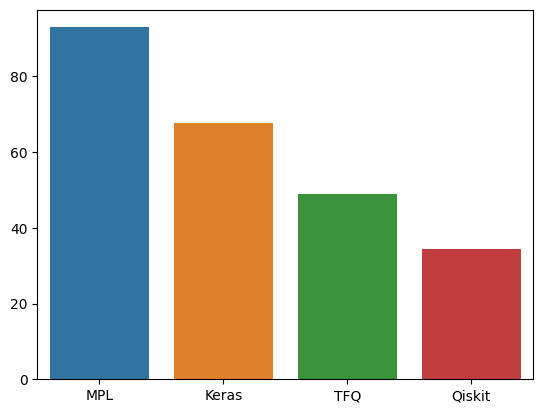

In [76]:
#seaborn.barplot(x=["SVC", "MPL","TFQ"],
            #y=[resultados_svc[0], resultados_mlp[0],qnn_accuracy])
    
seaborn.barplot(x=["MPL","Keras","TFQ","Qiskit"],y=[resultados_mlp[0], score[1]*100,test_acc*100,accuracy])

In [77]:
media_uso_cpu_entrenamiento_mlp = np.mean(cpu_percent_list_train_mlp)
media_uso_cpu_entrenamiento_keras = np.mean(cpu_percent_list_train_keras)
media_uso_cpu_entrenamiento_tfq = np.mean(cpu_percent_list_train_tfq)
media_uso_cpu_entrenamiento_q = np.mean(cpu_percent_list_train_q)

media_uso_cpu_test_mlp = np.mean(cpu_percent_list_test_mlp)
media_uso_cpu_test_keras = np.mean(cpu_percent_list_test_keras)
media_uso_cpu_test_tfq = np.mean(cpu_percent_list_test_tfq)
media_uso_cpu_test_q = np.mean(cpu_percent_list_test_q)

nombres = ['media_uso_cpu_entrenamiento_mlp','media_uso_cpu_entrenamiento_keras',
           'media_uso_cpu_entrenamiento_tfq','media_uso_cpu_entrenamiento_qiskit',
           'media_uso_cpu_test_mlp','media_uso_cpu_test_keras',
          'media_uso_cpu_test_tfq','media_uso_cpu_test_qiskit']

porcentajes = [media_uso_cpu_entrenamiento_mlp, media_uso_cpu_entrenamiento_keras,media_uso_cpu_entrenamiento_tfq
               ,media_uso_cpu_entrenamiento_q,media_uso_cpu_test_mlp,media_uso_cpu_test_keras, 
               media_uso_cpu_test_tfq,media_uso_cpu_test_q]


num_plots = len(porcentajes)
num_cols = min(num_plots, 2)
num_rows = (num_plots + num_cols - 1) // num_cols

# Create figure and subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Iterate over subplots and percentages
for i, (porcentaje, nombre) in enumerate(zip(porcentajes, nombres)):
    row = i // num_cols
    col = i % num_cols
    
    # Create pie chart with percentage and remaining percentage
    restante = 100 - porcentaje
    datos = [porcentaje, restante]
    axs[row, col].pie(datos, colors=['blue', 'white'], startangle=90, counterclock=False, wedgeprops={'width': 0.5, 'edgecolor': 'white'})
    
    # Add percentage as text in center of pie chart
    axs[row, col].text(0, 0, f'{np.around(porcentaje, 1)}%', ha='center', va='center', fontsize=20)
    axs[row, col].axis('equal')
    
    # Add title to subplot
    axs[row, col].set_title(nombre)

# Add spacing between subplots
fig.tight_layout()

# Show plot
plt.show()

/home/tomas/Escritorio/TFG/quantum_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

/home/tomas/Escritorio/TFG/quantum_env/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning:

invalid value encountered in scalar divide



ValueError: cannot convert float NaN to integer

ValueError: need at least one array to concatenate

<Figure size 1000x1000 with 8 Axes>

In [78]:
media_uso_ram_entrenamiento_mlp = np.mean(memory_usage_list_train_mlp)
media_uso_ram_entrenamiento_keras = np.mean(memory_usage_list_train_keras)
media_uso_ram_entrenamiento_tfq = np.mean(memory_usage_list_train_tfq)
media_uso_ram_entrenamiento_q = np.mean(memory_usage_list_train_q)

media_uso_ram_test_mlp = np.mean(memory_usage_list_test_mlp)
media_uso_ram_test_keras = np.mean(memory_usage_list_test_keras)
media_uso_ram_test_tfq = np.mean(memory_usage_list_test_tfq)
media_uso_ram_test_q = np.mean(memory_usage_list_test_q)

nombres = ['media_uso_ram_entrenamiento_mlp','media_uso_ram_entrenamiento_keras',
           'media_uso_ram_entrenamiento_tfq','media_uso_ram_entrenamiento_qiskit',
           'media_uso_ram_test_mlp','media_uso_ram_test_keras',
          'media_uso_ram_test_tfq','media_uso_ram_test_qiskit']

porcentajes = [media_uso_ram_entrenamiento_mlp, media_uso_ram_entrenamiento_keras,media_uso_ram_entrenamiento_tfq
               ,media_uso_ram_entrenamiento_q,media_uso_ram_test_mlp,media_uso_ram_test_keras, 
               media_uso_ram_test_tfq,media_uso_ram_test_q]


num_plots = len(porcentajes)
num_cols = min(num_plots, 2)
num_rows = (num_plots + num_cols - 1) // num_cols

# Create figure and subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Iterate over subplots and percentages
for i, (porcentaje, nombre) in enumerate(zip(porcentajes, nombres)):
    row = i // num_cols
    col = i % num_cols
    
    # Create pie chart with percentage and remaining percentage
    restante = 100 - porcentaje
    datos = [porcentaje, restante]
    axs[row, col].pie(datos, colors=['blue', 'white'], startangle=90, counterclock=False, wedgeprops={'width': 0.5, 'edgecolor': 'white'})
    
    # Add percentage as text in center of pie chart
    axs[row, col].text(0, 0, f'{np.around(porcentaje, 1)}%', ha='center', va='center', fontsize=20)
    axs[row, col].axis('equal')
    
    # Add title to subplot
    axs[row, col].set_title(nombre)

# Add spacing between subplots
fig.tight_layout()

# Show plot
plt.show()

ValueError: cannot convert float NaN to integer

ValueError: need at least one array to concatenate

<Figure size 1000x1000 with 8 Axes>

In [79]:
#PONER TIEMPOS ENTRENAMIENTO EN LOS ALGORITMOS, FALTA, IGUAL CON EL TESTEO, AHORA MISMO SOLO DE EJEMPLO
modelos = ["MPL", "Keras","TFQ","Qiskit"]
counts = [resultados_mlp[1],endTrainingTime_keras,endTrainingTime_tfq,endTrainingTime_q]
fig = plt.figure(dpi=100, figsize=(10,5))
ax = fig.gca()
seaborn.barplot(x=modelos, y=counts, ax=ax, orient="v")
ax.set_ylabel("Tiempo en segundos")
ax.set_xlabel("Modelo")
ax.set_title(f"Tiempo de entrenamiento")

NameError: name 'tiempo_entrenamieno_mlp' is not defined

Text(0.5, 1.0, 'Tiempo de entrenamiento')

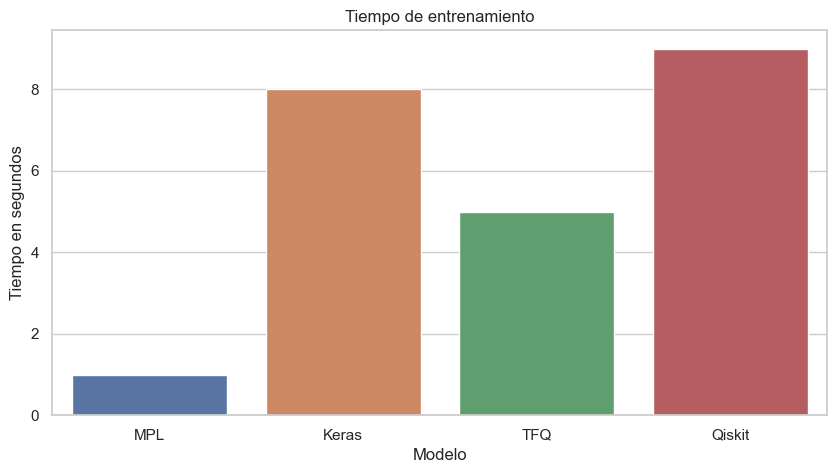

In [165]:
modelos = ["MPL", "Keras","TFQ","Qiskit"]
counts = [resultados_mlp[2],endTestingTime_keras,endTestingTime_tfq,endTestingTime_q]
fig = plt.figure(dpi=100, figsize=(10,5))
ax = fig.gca()
seaborn.barplot(x=modelos, y=counts, ax=ax, orient="v")
ax.set_ylabel("Tiempo en segundos")
ax.set_xlabel("Modelo")
ax.set_title(f"Tiempo de entrenamiento")